# 2D Finite-difference simulation (3 or 5-point) of fault-zone trapped waves
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.29

_Extend the (1D and/or 2D) codes by adding the option to use a fivepoint operator for the second derivative. Compare simulations with the three-point and five-point operators. Is the stability limit still the same? Make it an option to change between three-point and five-point operators. Estimate the number of points per wavelength you are using and investigate the accuracy of the simulation by looking for signs of numerical dispersion in the resulting seismograms._

<br>
<strong>Scenario: P-waves in reservoir  (p. 90)</strong><br>
"We want to simulate P-wave propagation in a reservoir scale model with maximum velocity $c_{max}$ = 5 km/s and minimum velocity $c_{min}$ = 3 km/s. The dominant frequency is chosen to be $f_0$ = 20 Hz (from the discussion of the source time function above we expect energy up to 50 Hz to be present in the waveforms). The dominant wavelength is $λ_0$ = $c/f_0$ = 150 m. For this exercise we simulate a spatial domain of 5 km × 5 km and use a grid point distance $dx$ = 10 m resulting in 15 grid points per wavelength for the dominant frequency. We examine the behaviour of the wavefield looking at the snapshots resulting from a source injected at the centre of the model."
 <br>
<br>
Note that the scalar acoustic wave equation is mathematically identical to the SH-wave-propagation problem (assuming constant density). So, in the case of fault-zone trapped waves that are predominantly observed for SH-type ground motions, this is a useful basic physical model." <br>

<br>
<strong>2D acoustic wave equation:</strong>
$$\partial_t^2 p(x, z, t) = c(x, z)^2 (\partial^2_x p(x, z, t) \partial^2_z p(x, z, t)) + s(x, z,t)$$

We can calculate a solution by iterating over the time elements:
$$p(t+dt) = 2p(t) - p(t-dt) + dt^2[c^2\partial^2_xp + s],$$ 

while simultaneously iterating over space using either 3-point operators
$$d^2_xp(x,z) \approx \frac{p(x+dx) - 2p(x) + p(x-dx)}{dx^2}$$
$$d^2_zp(x,z) \approx \frac{p(z+dz) - 2p(z) + p(z-dz)}{dz^2}$$ 


or 5-point operators:
$$d^2_xp(x,z) \approx -\frac{1}{12}p(x+2dx) + \frac{4}{3}p(x+dx) - \frac{5}{2}p(x) + \frac{4}{3}p(x-dx) - \frac{1}{12}p(x-d2x)$$
$$d^2_zp(x,z) \approx -\frac{1}{12}p(z+2dz) + \frac{4}{3}p(z+dz) - \frac{5}{2}p(z) + \frac{4}{3}p(z-dz) - \frac{1}{12}p(z-d2z)$$


We'll use the derivative of a Gaussian as our source time function (so that our resulting waveform is a Gaussian):
$$s(t) = -8f_0(t-t_0)e^{-(f_0(t-t_0))^2}$$

<br>
Meanwhile, the <strong>analytical solution</strong> is
$$p(t) = G(t) * s(t),$$
where 
$$G(t) =
\begin{cases}
    \begin{align}    
        0,                                      &\quad t \lt \frac{|x|}{c} \\
        \frac{1}{2c \sqrt{t^2-\frac{r^2}{c^2}}}, &\quad t \ge \frac{|x|}{c}
    \end{align}
\end{cases}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
operator = 5

xmax = 5            # spatial range (km)
zmax = 5
dx = .01            # distance between grid points (km)
dz = dx
nx = int(xmax/dx)   # number of grid points
nz = int(zmax/dz)
    
tmax = 1            # length of seismogram (s)
dt = .001           # time interval (s)
nt = int(tmax/dt)   # number of time steps
    
xsrc = 0
zsrc = 0            # z-coord. of source
xrec = 1            # x-coord. of receiver
zrec = 1.5          # z-coord. of source
f0 = 20             # dominant frequency (Hz)
t0 = .3             # time shift (s)
tsnap = .5          # time snapshot is taken (s)

x = np.arange(-xmax/2, xmax/2, dx)   # space
z = np.arange(-zmax/2, zmax/2, dz)
t = np.arange(0, tmax, dt)           # time

c = np.where(((x <= .1) & (x >= -.1)), 2.25, 3.00)    # piecewise wavefield velocity (km/s)
ind = np.linspace(0, len(c) - 1, nt, dtype=int)       # resize c from size nx to nt
c = c[ind]

# get indices of source & receiver locations (will be used to add source term/make seis in algorithm)
ixsrc, ixrec = round(((xsrc+xmax/2)/xmax)*len(x)), round(((xrec+xmax/2)/xmax)*len(x))
izsrc, izrec = round(((zsrc+zmax/2)/zmax)*len(z)), round(((zrec+zmax/2)/zmax)*len(z))

# get index of snapshot time (or closest to it):
itsnap = np.abs(t - tsnap).argmin()

# CFL criterion
eps = max(c)*dt/dx

# CFL criterion check
if operator == 3:
    if eps > 1:
        raise ValueError('Error: CFL criterion not satisfied! Ensure that c*dt/dx <= 1.')

if operator == 5:
    if eps > np.sqrt(3)/2:     # CFL condition is different for higher operators - see 5 pt stability limit exercise
        raise ValueError('CFL criterion not satisfied! Ensure that c*dt/dx <= sqrt(3)/2.')


print('# grid points in x:', nx, '\n# grid points in z:', nz, '\n# grid points in time:', nt)


# grid points in x: 500 
# grid points in z: 500 
# grid points in time: 1000


#### Source time function

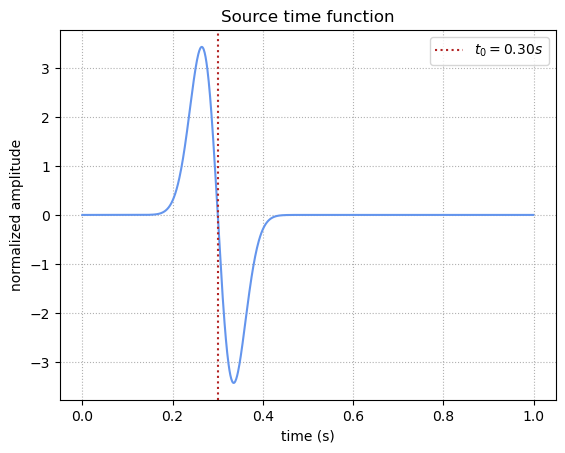

In [3]:
src = -8*f0*(t-t0)*np.exp(  -((t - t0)*f0)**2   )

plt.plot(t, src, 'cornflowerblue')
plt.axvline(t0, linestyle = ':', color = 'firebrick', label = '$t_0 = {:.2f} s$'.format(t0))
plt.xlabel('time (s)')
plt.ylabel('normalized amplitude')
plt.title('Source time function')
plt.legend()
plt.grid(linestyle = ':')

#### Finite-difference calculations

In [4]:
p = np.zeros((nx, nz))
pold = np.zeros((nx, nz))   # p(t-dt)
pnew = np.zeros((nx, nz))   # p(d+dt)
dx2p = np.zeros((nx, nz))   # 2nd derivative in space
dz2p = np.zeros((nx, nz))   # 2nd derivative in space
seis = np.zeros(nt)

for it in range(nt):

    # calculate partial derivatives
    if operator == 3:
        for ix in range(1, nx - 1):
            dx2p[ix, :] = (p[ix + 1, :] - 2 * p[ix, :] + p[ix - 1, :]) / dx**2
            
        for iz in range(1, nz - 1):
            dz2p[:, iz] = (p[:, iz + 1] - 2 * p[:, iz] + p[:, iz - 1]) / dz**2

    if operator == 5:
        for ix in range(2, nx-2):
            dx2p[ix, :] = (4*(p[ix + 1, :] + p[ix - 1, :])/3  -  5*p[ix, :]/2      - (p[ix + 2, :] + p[ix - 2, :])/12) / (dx**2)
         
        for iz in range(2, nz - 2):
            dz2p[:, iz] = (4*(p[:, iz + 1] + p[:, iz - 1])/3  -  5*p[:, iz]/2   - (p[:, iz + 2] + p[:, iz - 2])/12) / (dz**2)
    
    # time extrapolation
    pnew = 2 * p - pold + c[it]**2 * dt**2 * (dx2p + dz2p)
 
    # add source term at (ixsrc, izsrc)
    pnew[ixsrc, izsrc] = pnew[ixsrc, izsrc] + dt**2 * src[it] / np.sqrt(dx**2 + dz**2)

    # remap time levels
    pold = p
    p = pnew

    if it == itsnap:
        psnap = p
    
    # make seismogram
    seis[it] = p[ixrec, izrec]

#### Compare with analytical solution

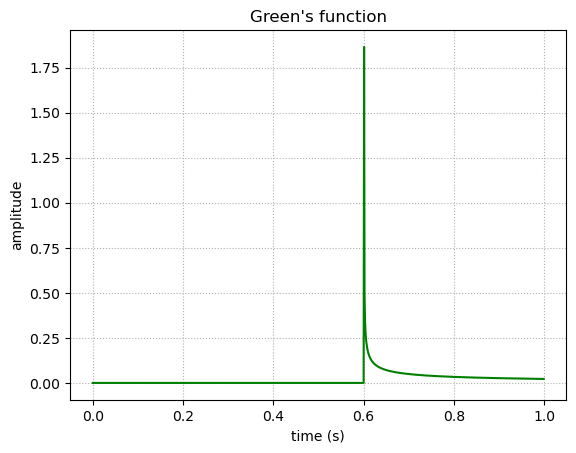

In [5]:
# Green's function:
G = np.zeros(len(t))
r = np.sqrt( (x[ixsrc]-x[ixrec])**2 + (z[izsrc]-z[izrec])**2 )

for it in range(nt):
    if (t[it]- r / c[it]) >= 0:
        G[it] = 1 / ( 2*np.pi*c[it]**2 * np.sqrt(np.abs(t[it]**2 - (r**2)/c[it]**2)) )

G = np.zeros(len(t))
r = np.sqrt( (x[ixsrc]-x[ixrec])**2 + (z[izsrc]-z[izrec])**2 )

for it in range(nt):
    if (t[it]- r / c[it]) >= 0:
        G[it] = 1 / ( 2*np.pi*c[it]**2 * np.sqrt(np.abs(t[it]**2 - (r**2)/c[it]**2)) )

plt.plot(t, G, 'g')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Green\'s function')
plt.grid(linestyle = ':')

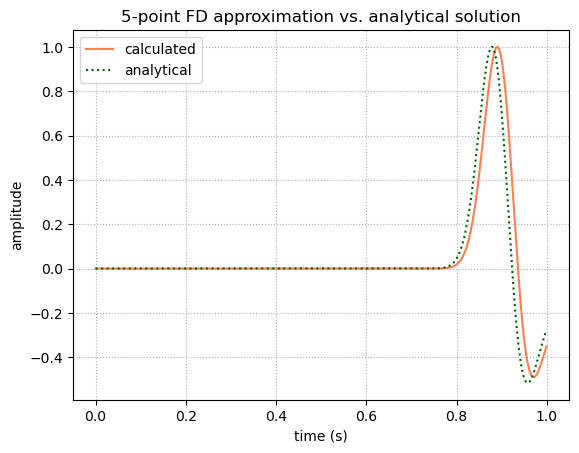

In [6]:
# analytical seismogram:
seis_a = np.convolve(G, src * dt)[:nt]

# plot to show comparison:
plt.plot(t, seis/max(seis), 'coral', label = 'calculated')
plt.plot(t, seis_a/max(seis_a), 'darkgreen', linestyle = ':', label = 'analytical')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('{:.0f}-point FD approximation vs. analytical solution'.format(operator))
plt.legend()
plt.grid(linestyle = ':')

### Numerical dispersion & grid points per wavelength

If we plot the phase velocity as a function of the number of grid points per $\lambda_0$, we can see how using too few points per wavelenth can lead to bad results due to numerical dispersion. The graph below shows the phase velocity for different values of the CFL criterion $\epsilon$. At $\epsilon$ = 1, the phase velocity is equal to the actual propagation velocity of the wave.

Note that we have to use at least 2 points per wavelength in order to stay above the Nyquist wavelength $\lambda_{Ny} = \frac{1}{2\lambda_0}$.

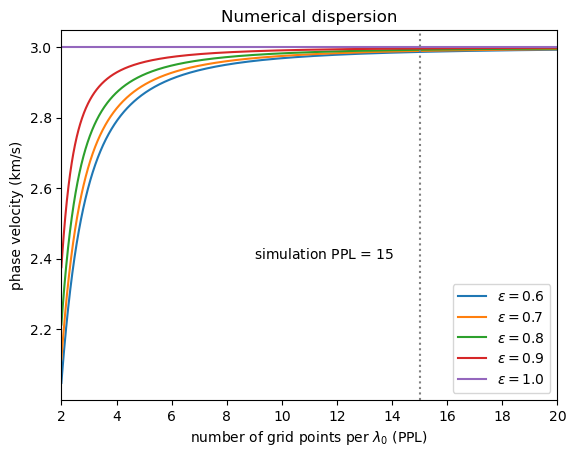

In [7]:
C = 3                # velocity (for simplicity, we'll only consider the area outside the fault zone)
L = C/f0             # domininant wavelength
L_ny = L/2           # Nyquist wavelength
ppl = L/dx           # number of points per dominant wavelength used in simulation
k = 2*np.pi*f0/C     # wavenumber

# now let's see what happens when we vary the ppl (for different values of epsilon)
DX = np.linspace(.0001, L_ny, 500 )       # distance between grid points (varies)
EPS = [.6, .7, .8, .9, 1.]               # epsilon (varies)
PPL = L/DX                               # number of points per dominant wavelength (varies)
DT     = np.zeros((len(EPS), len(DX)))   # time interval (varies)
CPHASE = np.zeros((len(EPS), len(DX)))   # phase velocity (varies)

# calculate phase velocity for different ppl values
for i in range(len(EPS)):
    DT[i, :] = EPS[i]*DX/C
    CPHASE[i, :] = 2/(k*DT[i,:])*np.arcsin(C*DT[i,:]/DX * np.sin(k*DX/2))
    plt.plot(PPL, CPHASE[i,:], label = '$\\epsilon =  {:.1f}$'.format(EPS[i]))

plt.xlim(2, ppl+ppl/3)
plt.xlabel('number of grid points per $\\lambda_0$ (PPL)')
plt.ylabel('phase velocity (km/s)')
plt.title('Numerical dispersion')
plt.axvline(ppl, linestyle = ':', color = 'gray')
plt.text(ppl - ppl/2.5, C*.8, 'simulation PPL = ${:.0f}$'.format(L/dx))
plt.legend(loc = 'lower right');
